In [ ]:
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

In [ ]:
%cd
from google.colab import files

uploaded=files.upload()
!cp kaggle.json ~/.kaggle/
%cd /content/gdrive/MyDrive/Colab Notebooks/S202 Hackathon
!kaggle datasets download -d abrahametry/aruzz22-5k-an-image-dataset-of-rice-varieties
!unzip dataset.zip

In [ ]:
%cd /content/gdrive/MyDrive/Colab Notebooks/S202 Hackathon


/content/gdrive/MyDrive/Colab Notebooks/S202 Hackathon


In [ ]:
!unzip dataset.zip

In [ ]:
!gsutil -m cp -r "/content/gdrive/MyDrive/Colab Notebooks/S202 Hackathon/1_TRAIN" /content
!gsutil -m cp -r "/content/gdrive/MyDrive/Colab Notebooks/S202 Hackathon/2_VALID" /content

In [ ]:
import random
train_dir = '/content/1_TRAIN/'
test_dir = '/content/2_VALID/'

train_shamp = ['/content/1_TRAIN/4_Shampakatari/ShompaKatari_4_{:04d}.jpg'.format(i) for i in range(1,1101)]
train_chini = ['/content/1_TRAIN/17_Chinigura_Polao/ChiniguraPolao_17_{:04d}.jpg'.format(i) for i in range(1,1101)]
valid_shamp = ['/content/2_VALID/4_Shampakatari/ShompaKatari_4_{:03d}.jpg'.format(i) for i in range(1,201)]
valid_chini = ['/content/2_VALID/17_Chinigura_Polao/ChiniguraPolao_17_{:03d}.jpg'.format(i) for i in range(1,201)]

# take first 2000 images of train_dogs and train_cats for training images
train_imgs = train_shamp[:1100] + train_chini[:1100]
valid_imgs = valid_shamp[:200] + valid_chini[:200]
random.shuffle(train_imgs)
random.shuffle(valid_imgs)

In [ ]:
%cd /content

import os
path = os.getcwd()
print ("Train shampa directory count:", len([name for name in os.listdir(path+'/1_TRAIN/4_Shampakatari')]))
print ("Train Chini directory count:", len([name for name in os.listdir(path+'/1_TRAIN/17_Chinigura_Polao')]))
print ("Test shampa directory count:", len([name for name in os.listdir(path+'/2_VALID/4_Shampakatari')]))
print ("Test Chini directory count:", len([name for name in os.listdir(path+'/2_VALID/17_Chinigura_Polao')]))

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
for image in train_imgs[0:3]:
    image = mpimg.imread(image)
    imgplot = plt.imshow(image)
    plt.show()

In [ ]:
import cv2

nrows = 150
ncols = 150
channels = 3

def readAndProcessImage(imageList):
    a,b=0,0
    x = []
    y = []
    index = 1
    for image in imageList:
        index += 1
        try:
            x.append(cv2.resize(cv2.imread(image,cv2.IMREAD_COLOR),(nrows,ncols),interpolation=cv2.INTER_CUBIC))
            if 'Shampa' in image:
                y.append(1)
                a+= 1
            elif 'Chini' in image:
                b+=1
                y.append(0)
        except Exception as e:
            print(str(e))

    return x,y,a,b
x, y,a,b= readAndProcessImage(train_imgs)
xv, yv,av,bv= readAndProcessImage(valid_imgs)
print(f"{a} {b} | {av} {bv}")

In [ ]:
import pickle

path = "/content/gdrive/MyDrive/Colab Notebooks/S202 Hackathon/"

# To save
f = open(path + "processedimages.pickle","wb")
pickle.dump([x,y],f)
f.close()
f = open(path + "processedimages_valid.pickle","wb")
pickle.dump([xv,yv],f)
f.close()

In [ ]:
# To load
f = open(path + "processedimages.pickle","rb")
data = pickle.load(f)
f.close()
x = data[0]
y = data[1]
print(x[0])
print(y[0])

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

x=np.array(x)
y=np.array(y)
sns.countplot(x = y)
plt.title('Labels for Shampakatari and Chinigura Polao')

In [ ]:
import pickle
import numpy as np

# To load
path = "/content/gdrive/MyDrive/Colab Notebooks/S202 Hackathon/"
f = open(path + "processedimages.pickle","rb")
data = pickle.load(f)
f.close()
f = open(path + "processedimages_valid.pickle","rb")
data_v = pickle.load(f)
f.close()
x = data[0]
y = data[1]
x_v = data_v[0]
y_v = data_v[1]
x_arr = np.array(x+x_v)
y_arr = np.array(y+y_v)
t_size = ((len(x_v)/(len(x)+len(x_v))) + (len(y_v)/(len(y)+len(y_v))))/2


# Splitting
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_arr,y_arr,test_size = t_size, random_state = 2)

# 20% to validation set, 80% to train set
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

# Obtain length of training set and validation set (should be 3200 and 800 respectively)
ntrain = len(x_train) if len(x_train) <= len(y_train) else len(y_train)
nval = len(x_val) if len(x_val) <= len(y_val) else len(y_val)

# Specify batch size (number of training examples used in one iteration)
batch_size = 1

# MODEL TIME!
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

model = models.Sequential()

# Multiple convolutional layers allow for hierarchical representations of your images
# E.g. Layer 1 learns the edges, Layer 2 is more abstract and learns the shapes form by the edges
# ... Layer 5 might be abstract enough to differentiate faces

# Pooling after each Convolution allows us to ignore where the features are on the image
# Furthermore, more EFFICIENT and FASTER models!

model.add(layers.Conv2D(32,(3,3),activation = 'relu',input_shape = (150,150,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3),activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))

# Converts our multi-dimensional arrays into one-dimensional arrays
model.add(layers.Flatten())

# Prevents overfitting by ignoring certain inputs
# Visual explanation: https://miro.medium.com/v2/resize:fit:1210/1*wDGvx0z0-nEB8zQHykvwPw.png
model.add(layers.Dropout(0.5))

# Dense layers are used to classify images
# relu sets any negative value to 0, leading to values of only 0 to a positive number, speeding up training
# sigmoid sets the output to be bounded from only 0 to 1, from relu's previously 0 to a positive number
# The final output being a range from 0 to 1 is suitable for our binary classification of cats and dogs
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1,activation = 'sigmoid'))

model.summary()

In [ ]:

# Binary Cross Entropy Loss: tracks incorrect labeling of the data class by a model,
# It penalise the model if deviations in probability occur into classifying the labels
# Low loss results in high accuracy in the model

# 1e-4 = 0.0001
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(learning_rate=1e-4),metrics=['acc'])

# The ImageDataGenerator() class takes our original images to create new transformed images
# The variations of the original images at each epoch will further train our model to recognise better

train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 40, width_shift_range = 0.2,
                                   height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2,
                                   horizontal_flip = True)
val_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 40, width_shift_range = 0.2,
                                   height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2,
                                   horizontal_flip = True)
# Use the Image Data Generator using flow()

train_generator = train_datagen.flow(x_train,y_train,batch_size = batch_size)
val_generator = val_datagen.flow(x_val,y_val,batch_size = batch_size)

# 8 epochs for now as a basic model. Lesser epochs usually might signify incomplete learning
# Always check the validation and training loss. If they stop dropping, you can stop further epochs

history = model.fit(train_generator, steps_per_epoch = ntrain//batch_size, epochs = 2,
                              validation_data = val_generator,
                              validation_steps = nval//batch_size)
#Save the model
%cd /content/gdrive/MyDrive/Colab Notebooks/S202 Hackathon
model.save_weights('model_weights.keras')
model.save('model_keras.keras')

from keras.models import load_model

# load model
model = load_model('model_keras.keras')
model.load_weights('model_weights.keras')

# summarize model.
model.summary()

In [ ]:
import cv2
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
def readAndProcessImage(imageList):
    s = 0
    c = 0
    x = []
    y = []
    index = 1
    for image in imageList:
        index += 1
        try:
            x.append(cv2.resize(cv2.imread(image,cv2.IMREAD_COLOR),(nrows,ncols),interpolation=cv2.INTER_CUBIC))
            if 'Sham' in image:
                s += 1
                y.append(1)
            elif 'Chin' in image:
                c += 1
                y.append(0)
        except Exception as e:
            print(str(e))
    return x,y,s,c

# Using 25 dogs and 25 cats from a test data set
dataset_S = ["/content/gdrive/MyDrive/Colab Notebooks/S202 Hackathon/1_TRAIN/4_Shampakatari/ShompaKatari_4_{:04d}.jpg".format(i) for i in range(100,126)]
dataset_C = ["/content/gdrive/MyDrive/Colab Notebooks/S202 Hackathon/1_TRAIN/17_Chinigura_Polao/ChiniguraPolao_17_{:04d}.jpg".format(i) for i in range(100,125)]
dataset = dataset_S + dataset_C
x_test,y_test,s,c = readAndProcessImage(dataset)
print(s)
print(c)

In [ ]:
x = np.array(x_test)
test_datagen = ImageDataGenerator(rescale = 1./255)
i = 0
text_labels = []
prediction = []
import matplotlib.pyplot as plt
plt.figure(figsize=(30,40))
for batch in test_datagen.flow(x,batch_size = 1):
    pred = model.predict(batch)
    if pred > 0.5:
        text_labels.append('Shampakatari')
        prediction.append(1)
    else:
        text_labels.append('Chinigura')
        prediction.append(0)
    i += 1
    if i % 50 == 0:
        break

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]
[[ 9 16]
 [16  9]]


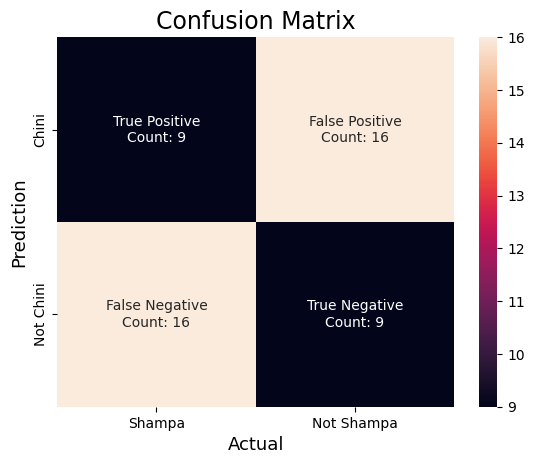

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Actual labels
print(y_test)

# Predicted labels
print(prediction)

#Create the NumPy array for actual and predicted labels.
actual    = np.array(y_test)
predicted = np.array(prediction)

#compute the confusion matrix.
cm = confusion_matrix(actual,predicted)
print(cm)

annotCM = [["True Positive\nCount: %d" %(cm[0][0]),"False Positive\nCount: %d" %(cm[0][1])],
           ["False Negative\nCount: %d" %(cm[1][0]),"True Negative\nCount: %d" %(cm[1][1])]]

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=annotCM,
            fmt='',
            xticklabels=['Shampa','Not Shampa'],
            yticklabels=['Chini','Not Chini'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()